In [1]:
#model does an ok job classifying by emotion
#however, it does mix up emotions 
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from glob import glob
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, DBSCAN

2025-02-01 13:55:59.016597: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Configuration
DATASET_ROOT = "/Volumes/JavaAOT/Documents/AI/ml_expressions/img_datasets/jaffe_dataset"  # <-- YOUR MAIN FOLDER PATH HERE
IMAGE_EXTENSIONS = ['*.jpg', '*.jpeg', '*.png', '*.bmp', '*.tiff']

def get_image_paths(root_dir, extensions):
    image_paths = []
    for ext in extensions:
        image_paths.extend(glob(os.path.join(root_dir, '**', ext), recursive=True))
    return image_paths

all_image_paths = get_image_paths(DATASET_ROOT, IMAGE_EXTENSIONS)
print(f"Found {len(all_image_paths)} images in nested folders")

Found 213 images in nested folders


In [3]:
#3 --- Use a Pretrained Emotion Recognition Model ---
# Get all image paths from nested folders
def get_emotion_model():
    model_path = '/Volumes/JavaAOT/Documents/AI/ml_expressions/img_datasets/fer2013_mini_XCEPTION.99-0.65.hdf5'
    return tf.keras.models.load_model(model_path, compile=False)

# Load the emotion model and remove its top classification layer to extract emotion-specific features.
emotion_model = get_emotion_model()
# For example, assume we remove the last layer to obtain a feature vector.
# Adjust 'layers[-2]' if your model architecture differs.
base_model = tf.keras.Model(inputs=emotion_model.input, outputs=emotion_model.layers[-2].output)

# Image preprocessing function remains similar.
def preprocess_image(path):
    try:
        # Load image in grayscale mode and resize to 64x64 (as expected by the emotion model)
        img = tf.keras.preprocessing.image.load_img(path, color_mode='grayscale', target_size=(64, 64))
        img_array = tf.keras.preprocessing.image.img_to_array(img)
        # Optionally normalize the image data (Mini-Xception often expects pixel values in [0,1] or [-1,1])
        return img_array / 255.0
    except Exception as e:
        print(f"Error loading {path}: {str(e)}")
        return None

# Feature extraction function using the emotion-based feature extractor.
def extract_features(image_paths, batch_size=32):
    features = []
    for i in range(0, len(image_paths), batch_size):
        batch_paths = image_paths[i:i+batch_size]
        batch_images = []
        for p in batch_paths:
            img = preprocess_image(p)
            if img is not None:
                batch_images.append(img)
        if batch_images:
            batch_features = base_model.predict(np.array(batch_images))
            features.extend(batch_features)
    return np.array(features)

In [4]:
# 4 --- Dimensionality Reduction & Clustering ---
def cluster_images(features, n_clusters=8):
    # Flatten features to (n_samples, n_features)
    flattened = features.reshape(features.shape[0], -1)
    
    # Dynamically set the number of PCA components
    n_components = min(50, flattened.shape[1])
    pca = PCA(n_components=n_components)
    reduced = pca.fit_transform(flattened)
    
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    clusters = kmeans.fit_predict(reduced)
    
    tsne = TSNE(n_components=2, random_state=42)
    vis_features = tsne.fit_transform(reduced)
    
    plt.figure(figsize=(12, 8))
    plt.scatter(vis_features[:, 0], vis_features[:, 1], c=clusters, cmap='tab20')
    plt.title('Cluster Visualization')
    plt.show()
    
    return clusters

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 398ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 353ms/step


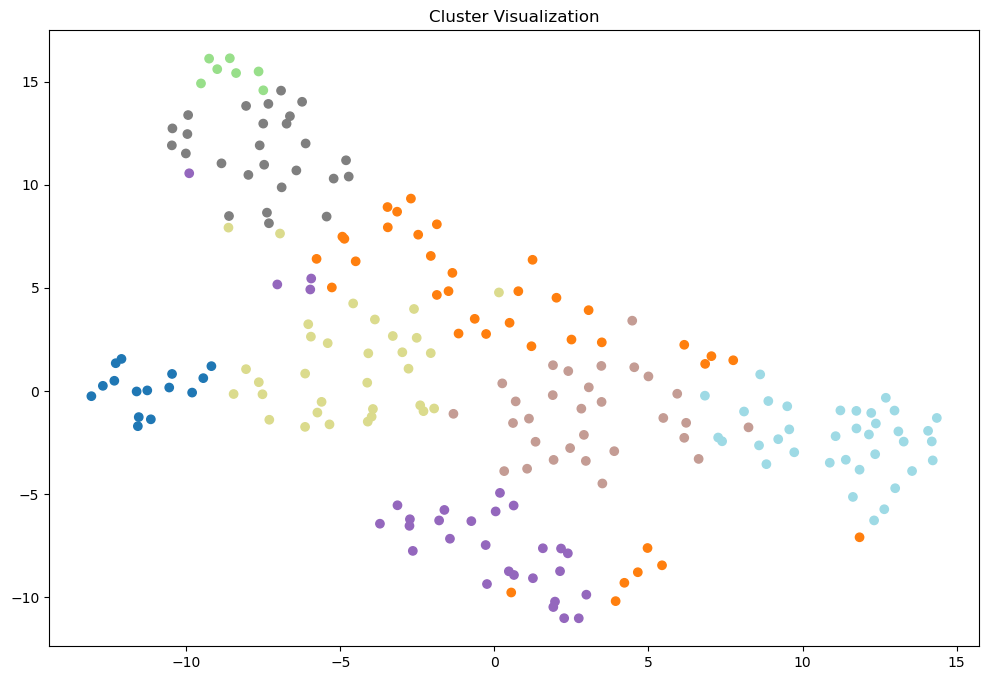

interactive(children=(IntSlider(value=0, description='cluster', max=7), Output()), _dom_classes=('widget-inter…

In [5]:
# 5 --- Interactive Cluster Labeling ---
from ipywidgets import interact, IntSlider
import ipyplot

def review_cluster(image_paths, clusters, cluster_id):
    cluster_images = [path for path, c in zip(image_paths, clusters) if c == cluster_id]
    ipyplot.plot_images(
        cluster_images[:50],
        max_images=50,
        img_width=150,
        force_b64=True
    )

# Extract features and cluster them.
features = extract_features(all_image_paths)
clusters = cluster_images(features)

@interact(cluster=IntSlider(min=0, max=int(np.max(clusters)), step=1))
def show_cluster(cluster):
    review_cluster(all_image_paths, clusters, cluster)

In [ ]:
# 6 --- Semi-Supervised Training Pipeline ---
from tensorflow.keras import layers, models
from scipy import stats

pseudo_labels = clusters  # Use cluster assignments as pseudo-labels

def create_model():
    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(len(np.unique(pseudo_labels)), activation='softmax')
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy')
    return model

initial_model = create_model()
# Preprocess all images for training
train_images = np.array([preprocess_image(p) for p in all_image_paths])
initial_model.fit(
    x=train_images,
    y=pseudo_labels,
    epochs=10,
    validation_split=0.2
)

x_test = train_images  # Re-use preprocessed images for prediction
preds = initial_model.predict(x_test)
confidences = np.max(preds, axis=1)
threshold = np.quantile(confidences, 0.9)
high_confidence_samples = [p for p, c in zip(all_image_paths, confidences) if c > threshold]

In [ ]:
# 7 --- Active Learning Interface ---
import csv
from IPython.display import display, clear_output
import ipywidgets as widgets

label_selector = widgets.Dropdown(options=['anger', 'contempt', 'disgust', 'fear', 'happiness', 'neutral', 'sadness', 'surprise'])
image_display = widgets.Output()
save_button = widgets.Button(description="Save Label")
current_index = 0
labels = {}

def show_next_image(b):
    global current_index
    with image_display:
        clear_output()
        display(tf.keras.preprocessing.image.load_img(high_confidence_samples[current_index]))
        
def save_label(b):
    labels[high_confidence_samples[current_index]] = label_selector.value
    show_next_image(None)
    current_index += 1

save_button.on_click(save_label)
display(widgets.VBox([image_display, label_selector, save_button]))

In [ ]:
# 9 --- Final Model Training ---
# Combine pseudo-labels and manual labels.
final_labels = {}
for path, cluster in zip(all_image_paths, clusters):
    if path in labels:
        final_labels[path] = labels[path]
    else:
        final_labels[path] = f"cluster_{cluster}"

# Define your target emotion labels.
emotion_labels = ['anger', 'disgust', 'fear', 'happiness', 'neutral', 'sadness', 'surprise']

# For this Option 1 test, we assume manual mapping of clusters to emotions has been done externally.
# (If a cluster label is not in emotion_labels, you might need to handle it accordingly.)
label_mapping = {emotion: idx for idx, emotion in enumerate(emotion_labels)}
try:
    y = np.array([label_mapping[final_labels[p]] for p in all_image_paths])
except KeyError as e:
    print("Mapping error:", e)
    # Here you might decide to filter out or remap cluster labels

final_model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(len(emotion_labels), activation='softmax')
])

final_model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Ensure compute_class_weights is defined or remove class_weight argument.
def compute_class_weights(y):
    from sklearn.utils import class_weight
    classes = np.unique(y)
    cw = class_weight.compute_class_weight('balanced', classes=classes, y=y)
    return dict(zip(classes, cw))

final_model.fit(
    x=train_images,
    y=y,
    epochs=30,
    validation_split=0.2,
    class_weight=compute_class_weights(y)
)
